In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,FunctionTransformer,StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,f1_score,make_scorer,roc_auc_score

import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import Recall

In [2]:
df=pd.read_csv("processed.csv")

In [3]:
df

,id,inning,over,ball,batsman,bowler,batsman_runs,is_wicket,batting_team,bowling_team,toss_decision,venue,Year,total_runs,venue_encoded,batsman_encoded,bowler_encoded
0,1304047,2,19,6,LH Ferguson,DJ Bravo,1,0,Kolkata Knight Riders,Chennai Super Kings,False,Wankhede Stadium,2022,126,22,230,299
1,1304047,1,0,1,RD Gaikwad,Umesh Yadav,0,0,Chennai Super Kings,Kolkata Knight Riders,False,Wankhede Stadium,2022,125,22,379,291
2,1304047,1,0,2,RD Gaikwad,Umesh Yadav,0,0,Chennai Super Kings,Kolkata Knight Riders,False,Wankhede Stadium,2022,125,22,379,291
3,1304047,1,0,3,RD Gaikwad,Umesh Yadav,0,0,Chennai Super Kings,Kolkata Knight Riders,False,Wankhede Stadium,2022,125,22,379,291
4,1304047,1,0,4,RD Gaikwad,Umesh Yadav,0,1,Chennai Super Kings,Kolkata Knight Riders,False,Wankhede Stadium,2022,125,22,379,291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119344,1237181,1,12,5,RR Pant,NM Coulter-Nile,0,0,Delhi Capitals,Mumbai Indians,True,Dubai International Cricket Stadium,2020,152,10,357,256
119345,1237181,1,12,6,RR Pant,NM Coulter-Nile,1,0,Delhi Capitals,Mumbai Indians,True,Dubai International Cricket Stadium,2020,152,10,357,256
119346,1237181,1,13,1,RR Pant,Krunal Pandya,0,0,Delhi Capitals,Mumbai Indians,True,Dubai International Cricket Stadium,2020,152,10,357,286
119347,1237181,1,13,2,RR Pant,Krunal Pandya,1,0,Delhi Capitals,Mumbai Indians,True,Dubai International Cricket Stadium,2020,152,10,357,286


# Feature engineering

In [9]:
encode_=LabelEncoder()

In [10]:
df['batting_team']=encode_.fit_transform(df['batting_team'])
df['bowling_team']=encode_.fit_transform(df['bowling_team'])

Here the batting team and bowling team are transformed

In [11]:
df.describe()

,id,inning,over,ball,batsman_runs,is_wicket,batting_team,bowling_team,Year,total_runs,venue_encoded,batsman_encoded,bowler_encoded
count,1.193490e+05,119349.000000,119349.000000,119349.000000,119349.000000,119349.000000,119349.000000,119349.000000,119349.000000,119349.000000,119349.000000,119349.000000,119349.000000
mean,1.150045e+06,1.480515,9.229830,3.534776,1.305910,0.049753,7.050608,7.045958,2019.003829,157.090273,15.955827,313.915609,245.362626
std,1.619722e+05,0.499622,5.677503,1.701476,1.668885,0.217436,4.248420,4.250745,2.695789,28.860176,7.160717,59.780677,59.247977
min,8.297050e+05,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,56.000000,2.000000,0.000000,0.000000
25%,1.082600e+06,1.000000,4.000000,2.000000,0.000000,0.000000,4.000000,4.000000,2017.000000,140.000000,10.000000,287.000000,219.000000
50%,1.178393e+06,1.000000,9.000000,4.000000,1.000000,0.000000,8.000000,8.000000,2019.000000,158.000000,19.000000,330.000000,266.000000
75%,1.304069e+06,2.000000,14.000000,5.000000,1.000000,0.000000,11.000000,11.000000,2022.000000,176.000000,22.000000,357.000000,291.000000
max,1.370353e+06,2.000000,19.000000,6.000000,6.000000,1.000000,13.000000,13.000000,2023.000000,244.000000,27.000000,382.000000,305.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119349 entries, 0 to 119348
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               119349 non-null  int64 
 1   inning           119349 non-null  int64 
 2   over             119349 non-null  int64 
 3   ball             119349 non-null  int64 
 4   batsman          119349 non-null  object
 5   bowler           119349 non-null  object
 6   batsman_runs     119349 non-null  int64 
 7   is_wicket        119349 non-null  int64 
 8   batting_team     119349 non-null  int64 
 9   bowling_team     119349 non-null  int64 
 10  toss_decision    119349 non-null  bool  
 11  venue            119349 non-null  object
 12  Year             119349 non-null  int64 
 13  total_runs       119349 non-null  int64 
 14  venue_encoded    119349 non-null  int64 
 15  batsman_encoded  119349 non-null  int64 
 16  bowler_encoded   119349 non-null  int64 
dtypes: bool(1)

In [13]:
x=df[['inning','over', 'ball', 'venue_encoded', 'toss_decision', 'batsman_encoded','bowler_encoded',
      'batting_team','bowling_team','Year']]
y=df['is_wicket']
z=df['batsman_runs']

Here we have selected the feature columns and target columns

In [14]:
X_train,X_test,y_train,y_test,z_train,z_test=train_test_split(x,y,z,random_state=23)

## Smote

In [15]:
sm_y=SMOTE(sampling_strategy=0.6,k_neighbors=1,random_state=22)
X_train_y,y_train=sm_y.fit_resample(X_train,y_train)


sm_z = SMOTE(k_neighbors=1, random_state=22)
X_train_z, z_train = sm_z.fit_resample(X_train, z_train)

Here we have sampled the dataset using Smote

## PCA

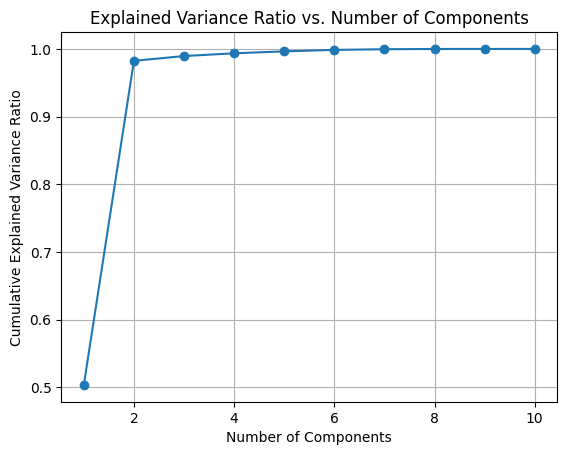

In [16]:
max_components = x.shape[1]

# Create PCA instance
pca = PCA(n_components=max_components)
pca.fit(x)

# Calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.plot(range(1, max_components + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

plot for showing elbow point for no. of components

In [17]:
def fit_print_y(p,X_train=X_train_y,X_test=X_test,y_train=y_train,y_test=y_test):
    p.fit(X_train,y_train)
    y_train_pred=p.predict(X_train)
    y_test_pred=p.predict(X_test)
    
    print("\033[1m" + "Test Set Classification Report:" + "\033[0m",end='\n\n\n')
    print(classification_report(y_test_pred, y_test))
    
    print("\n" + "="*60 + "\n",end='\n\n')
    
    print("\033[1m" + "Train Set Classification Report:" + "\033[0m",end='\n\n\n')
    print(classification_report(y_train_pred, y_train))
    
    y_pred_proba = p.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("\n" + "="*60 + "\n",end='\n\n')
    print(f"ROC AUC Score: {roc_auc:.4f}")

In [40]:
def fit_print_z(p,X_train=X_train_z,X_test=X_test,z_train=z_train,z_test=z_test):
    p.fit(X_train,z_train)
    z_train_pred=p.predict(X_train_z)
    z_test_pred=p.predict(X_test)
    
    print("\033[1m" + "Test Set Classification Report:" + "\033[0m",end='\n\n\n')
    print(classification_report(z_test_pred, z_test))
    
    print("\n" + "="*60 + "\n",end='\n\n')
    
    print("\033[1m" + "Train Set Classification Report:" + "\033[0m",end='\n\n\n')
    print(classification_report(z_train_pred, z_train))

These above 2 fuction fits and provides classification report of both Target variables Y and Z repectively

# Pipeline for wickets

In [176]:
p1 = Pipeline([
    ('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=4)),
    ('Logistic Regression', LogisticRegression(solver='liblinear', C=0.001, penalty='l1'))])
fit_print_y(p1)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.88      0.96      0.91     26843
           1       0.23      0.09      0.13      3974

    accuracy                           0.84     30817
   macro avg       0.55      0.52      0.52     30817
weighted avg       0.79      0.84      0.81     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.88      0.67      0.76    114465
           1       0.29      0.58      0.38     26056

    accuracy                           0.65    140521
   macro avg       0.58      0.63      0.57    140521
weighted avg       0.77      0.65      0.69    140521




ROC AUC Score: 0.5920


Here we have fitted Logistic Regression model after scaling using Standard Scaler and PCA.
We have taken n_components as 2 and hyperparameters of LogisticRegression with solver liblinear and penalty 'l1'

### MinMaxScaler

In [118]:
p3=Pipeline([
    ('Scaler',MinMaxScaler()),
    ('PCA', PCA(n_components=2)),
    ('Logistic Regression',LogisticRegression(solver='liblinear',C=0.01,penalty='l1'))
])
fit_print_y(p3)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.73      0.95      0.82     22313
           1       0.30      0.05      0.09      8504

    accuracy                           0.70     30817
   macro avg       0.51      0.50      0.46     30817
weighted avg       0.61      0.70      0.62     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.73      0.71      0.72     89865
           1       0.50      0.52      0.51     50656

    accuracy                           0.64    140521
   macro avg       0.61      0.62      0.62    140521
weighted avg       0.65      0.64      0.64    140521




ROC AUC Score: 0.5163


### RobustScaler 

In [119]:
p4=Pipeline([
    ('Scaler',RobustScaler()),
    ('PCA', PCA(n_components=2)),
    ('Logistic Regression',LogisticRegression(solver='liblinear',penalty="l2",C=0.1))
])
fit_print_y(p4)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.93      0.95      0.94     28498
           1       0.14      0.09      0.11      2319

    accuracy                           0.89     30817
   macro avg       0.53      0.52      0.53     30817
weighted avg       0.87      0.89      0.88     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.93      0.65      0.76    125586
           1       0.16      0.58      0.26     14935

    accuracy                           0.64    140521
   macro avg       0.55      0.62      0.51    140521
weighted avg       0.85      0.64      0.71    140521




ROC AUC Score: 0.6076


### MaxAbsScaler

In [160]:
p5=Pipeline([
    ('Scaler',MaxAbsScaler()),
    ('PCA', PCA(n_components=2)),
    ('Logistic Regression',LogisticRegression(solver='liblinear',penalty="l2",C=0.01))
])
fit_print_y(p5)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       1.00      0.95      0.98     30817
           1       0.00      0.00      0.00         0

    accuracy                           0.95     30817
   macro avg       0.50      0.48      0.49     30817
weighted avg       1.00      0.95      0.98     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       1.00      0.63      0.77    140521
           1       0.00      0.00      0.00         0

    accuracy                           0.63    140521
   macro avg       0.50      0.31      0.38    140521
weighted avg       1.00      0.63      0.77    140521



C:\Users\shahi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shahi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shahi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le




ROC AUC Score: 0.5221


We have used different Scaling techniques before fitting model using LogisticRegression
Among this Standard Scalers have shown the best precision and recall


## Decision Tree

In [121]:
p6=Pipeline([
    ('Scaler',StandardScaler()),
    ('PCA', PCA(n_components=4)),
    ('DT',DecisionTreeClassifier(max_depth=5))
])
fit_print_y(p6)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.88      0.96      0.92     26965
           1       0.23      0.09      0.13      3852

    accuracy                           0.85     30817
   macro avg       0.56      0.52      0.52     30817
weighted avg       0.80      0.85      0.82     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.88      0.67      0.76    114765
           1       0.29      0.59      0.39     25756

    accuracy                           0.66    140521
   macro avg       0.58      0.63      0.58    140521
weighted avg       0.77      0.66      0.69    140521




ROC AUC Score: 0.5857


## Random Forest

In [35]:
p7=Pipeline([(
    'Scaler',StandardScaler()),
    ('PCA', PCA(n_components=2)),
    ('Random Forest',RandomForestClassifier(n_estimators=100,max_depth=10,random_state=1))
])
fit_print_y(p7)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.90      0.95      0.93     26721
           1       0.21      0.10      0.14      3117

    accuracy                           0.86     29838
   macro avg       0.55      0.53      0.53     29838
weighted avg       0.83      0.86      0.84     29838




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.91      0.68      0.78    113497
           1       0.29      0.65      0.40     22706

    accuracy                           0.67    136203
   macro avg       0.60      0.66      0.59    136203
weighted avg       0.80      0.67      0.71    136203




ROC AUC Score: 0.6072


In [38]:
with open('RF_1.pkl','wb') as f:
    pickle.dump(p7,f)

## KNN

In [128]:
p8=Pipeline([('Scaler',StandardScaler()),('PCA', PCA(n_components=4)),('KNN',KNeighborsClassifier())])
fit_print_y(p8)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.81      0.95      0.87     24769
           1       0.24      0.06      0.09      6048

    accuracy                           0.78     30817
   macro avg       0.52      0.51      0.48     30817
weighted avg       0.69      0.78      0.72     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.87      0.93      0.90     81637
           1       0.89      0.80      0.84     58884

    accuracy                           0.88    140521
   macro avg       0.88      0.86      0.87    140521
weighted avg       0.88      0.88      0.87    140521




ROC AUC Score: 0.5324


## GaussianNB

In [129]:
p9=Pipeline([('Scaler',StandardScaler()),('PCA', PCA(n_components=4)),('NB',GaussianNB())])
fit_print_y(p9)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.87      0.96      0.91     26776
           1       0.23      0.08      0.12      4041

    accuracy                           0.84     30817
   macro avg       0.55      0.52      0.52     30817
weighted avg       0.79      0.84      0.81     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.87      0.68      0.76    113184
           1       0.30      0.58      0.40     27337

    accuracy                           0.66    140521
   macro avg       0.59      0.63      0.58    140521
weighted avg       0.76      0.66      0.69    140521




ROC AUC Score: 0.5758


# Pipeline for Runs

In [177]:
p1 = Pipeline([
    ('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=6)),
    ('Logistic Regression', LogisticRegression(solver='liblinear'))])
fit_print_z(p1)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.20      0.38      0.26      6283
           1       0.22      0.40      0.29      6383
           2       0.07      0.07      0.07      1750
           3       0.11      0.00      0.00      4638
           4       0.06      0.15      0.08      1408
           5       0.44      0.00      0.00      6227
           6       0.19      0.08      0.11      4128

    accuracy                           0.18     30817
   macro avg       0.18      0.16      0.12     30817
weighted avg       0.22      0.18      0.14     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.21      0.19      0.20     39162
           1       0.22      0.23      0.23     34100
           2       0.09      0.22      0.13     14730
           3       0.33      0.22      0.27     52478
           4       0.05      0.24      0.09      7728
      

## Decision Tree

In [178]:
fit_print_z(p6)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.05      0.41      0.09      1435
           1       0.11      0.40      0.17      3176
           2       0.00      0.06      0.01        80
           3       0.32      0.00      0.01      9534
           4       0.10      0.13      0.12      2781
           5       0.33      0.00      0.00      4148
           6       0.41      0.07      0.12      9663

    accuracy                           0.10     30817
   macro avg       0.19      0.15      0.07     30817
weighted avg       0.29      0.10      0.07     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.05      0.23      0.08      7248
           1       0.11      0.27      0.16     15180
           2       0.00      0.29      0.01       543
           3       0.57      0.24      0.34     83566
           4       0.11      0.20      0.14     20155
      

## Random Forest

In [ ]:
p13=Pipeline([('Scaler',StandardScaler()),('PCA', PCA(n_components=10)),('Random Forest',RandomForestClassifier(n_estimators=350,random_state=22))])
fit_print_z(p13)

In [54]:
with open('RF_2.pkl','wb') as f:
    pickle.dump(p13,f)

## KNN

In [63]:
fit_print_z(p4)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.32      0.40      0.36      9541
           1       0.26      0.40      0.32      7497
           2       0.16      0.07      0.10      4451
           3       0.02      0.00      0.00       742
           4       0.17      0.13      0.15      4678
           5       0.00      0.00      0.00        92
           6       0.15      0.07      0.10      3816

    accuracy                           0.26     30817
   macro avg       0.16      0.15      0.15     30817
weighted avg       0.23      0.26      0.24     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.55      0.54      0.55     35931
           1       0.48      0.59      0.53     28988
           2       0.80      0.72      0.76     39818
           3       0.99      0.94      0.97     37802
           4       0.67      0.70      0.69     34302
      

## GuassianNB 

In [64]:
fit_print_z(p5)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.12      0.41      0.19      3509
           1       0.22      0.41      0.29      6354
           2       0.08      0.07      0.08      2045
           3       0.08      0.00      0.01      2600
           4       0.11      0.14      0.12      2724
           5       0.56      0.00      0.00      7946
           6       0.27      0.08      0.13      5639

    accuracy                           0.16     30817
   macro avg       0.21      0.16      0.11     30817
weighted avg       0.27      0.16      0.12     30817




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.12      0.24      0.16     18745
           1       0.22      0.23      0.23     34015
           2       0.10      0.22      0.14     16576
           3       0.16      0.24      0.19     24048
           4       0.10      0.21      0.14     18039
      

## Neural Network

In [99]:
X_train_y = X_train_y.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics= tf.keras.metrics.Recall() )
history = model.fit(X_train_y, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
4392/4392 [==============================] - 7s 1ms/step - loss: 1.2667 - recall_2: 0.4187 - val_loss: 0.2083 - val_recall_2: 0.0060
Epoch 2/20
4392/4392 [==============================] - 6s 1ms/step - loss: 0.8476 - recall_2: 0.4281 - val_loss: 1.5728 - val_recall_2: 0.8985
Epoch 3/20
4392/4392 [==============================] - 6s 1ms/step - loss: 0.7532 - recall_2: 0.4250 - val_loss: 0.2146 - val_recall_2: 0.0013
Epoch 4/20
4392/4392 [==============================] - 7s 2ms/step - loss: 0.7036 - recall_2: 0.4198 - val_loss: 0.2428 - val_recall_2: 0.0100
Epoch 5/20
4392/4392 [==============================] - 7s 2ms/step - loss: 0.6710 - recall_2: 0.4125 - val_loss: 0.9690 - val_recall_2: 0.7408
Epoch 6/20
4392/4392 [==============================] - 6s 1ms/step - loss: 0.6465 - recall_2: 0.3991 - val_loss: 0.2902 - val_recall_2: 0.0588
Epoch 7/20
4392/4392 [==============================] - 6s 1ms/step - loss: 0.6310 - recall_2: 0.3845 - val_loss: 0.8265 - val_recall_2:

In [100]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print(classification_report(model.predict(X_test)>0.4, y_test))

964/964 [==============================] - 1s 990us/step - loss: 0.3795 - recall_2: 0.1129
Test Loss: 0.3795357346534729
Test Accuracy: 0.11289244890213013
964/964 [==============================] - 1s 769us/step
              precision    recall  f1-score   support

       False       0.82      0.96      0.88     25040
        True       0.25      0.07      0.10      5777

    accuracy                           0.79     30817
   macro avg       0.53      0.51      0.49     30817
weighted avg       0.71      0.79      0.73     30817



In [28]:
def build_model(num_units_1=64, num_units_2=64):
    model = Sequential()
    model.add(Dense(units=num_units_1, activation='relu', input_dim=4))
    model.add(Dense(units=num_units_2, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])
    return model

model = KerasClassifier(model=build_model, verbose=0,epochs=20,batch_size=32)

In [29]:
class DataConversionStep(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.astype(np.float32)
        return X

In [30]:
pNN=Pipeline([('Scaler',StandardScaler()),('PCA', PCA(n_components=4)),('ConvertDataTypes', DataConversionStep()),('NN',KerasClassifier(model=build_model, verbose=0,epochs=20,batch_size=32))])
fit_print_y(pNN,X_train=X_train_y,y_train=y_train)

Test Set Classification Report:


              precision    recall  f1-score   support

           0       0.84      0.95      0.89     24884
           1       0.23      0.07      0.11      4954

    accuracy                           0.81     29838
   macro avg       0.53      0.51      0.50     29838
weighted avg       0.74      0.81      0.76     29838




Train Set Classification Report:


              precision    recall  f1-score   support

           0       0.84      0.71      0.77    101285
           1       0.42      0.61      0.50     34918

    accuracy                           0.68    136203
   macro avg       0.63      0.66      0.63    136203
weighted avg       0.73      0.68      0.70    136203




ROC AUC Score: 0.5501
